In [321]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigsh

In [322]:
def Gibbs(qtilde,x0,z):
  p = 0.5
  h = qtilde * x0 + sqrt(qtilde) * z
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))

def Gauss(z):
  return exp(-z*z/2)/sqrt(2*pi)

def ExpectGibbsRad(qtilde):
  p = 0.5
  BOUNDS = 10
  #x0 = 1  
  av_fp = lambda z: Gauss(z) * p * (Gibbs(qtilde,1,z))**2
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
  #x0 = -1  
  av_fm = lambda z: Gauss(z) * p * (Gibbs(qtilde,-1,z))**2
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
  #x0 = 0
  av_fz = lambda z: Gauss(z) * (1-2*p) * (Gibbs(qtilde,0,z))**2
  av_zero, err= integrate.quad(av_fz, -BOUNDS, BOUNDS)
  return av_plus + av_zero + av_minus

def ExpectGibbs(qtilde,prior):
  if(prior == 'gaussian'):
        return 1 - 1/(qtilde + 1)
  elif prior == 'rademacher':
        return ExpectGibbsRad(qtilde)

def iterate(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior):
  damping = 0.2
  term1 =  ExpectGibbs(Qtilde1,prior)
  term2 = ExpectGibbs(Qtilde2,prior)
  newQtilde1 = (rho1/Delta_11) * term1 + (rho2/Delta_12) * term2
  newQtilde2 = (rho1/Delta_12) * term1 + (rho2/Delta_22) * term2
  return (1-damping)*newQtilde1 + damping*Qtilde1, (1-damping)*newQtilde2 + damping*Qtilde2, np.sqrt((newQtilde1-Qtilde1)**2 + (newQtilde2-Qtilde2)**2)
def Solve_Q(Qtilde1,Qtilde2,rho1,rho2,Delta_11,Delta_12,Delta_22,prior):
    convergence = 1000
    while (convergence > 1e-3):
        Qtilde1, Qtilde2, convergence = iterate(Qtilde1,Qtilde2, rho1, rho2, Delta_11, Delta_12, Delta_22, prior)
        
    return Qtilde1, Qtilde2

In [323]:
def optimal_curve(start, end, points, diag_scalar, off_diag_scalar, prior):

    rho1, rho2 = 0.5, 0.5

    MMSEVec = []
    paramvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
      Delta11 = param
      Delta12 = off_diag_scalar * param 
      Delta22 = diag_scalar * param
    
      Qtilde1 = 1
      Qtilde2 = 1
    
      Qtilde1, Qtilde2 = Solve_Q(Qtilde1, Qtilde2, rho1, rho2, Delta11, Delta12, Delta22,prior)
      MMSEVec.append(1 - np.sqrt(rho1**2 * ExpectGibbs(Qtilde1,prior)**2 + 
                           2 * rho1 * rho2 *  ExpectGibbs(Qtilde1,prior) * ExpectGibbs(Qtilde2,prior) + 
                           rho2**2 * ExpectGibbs(Qtilde2,prior)**2))
      paramvec.append(param)
    
    return {'parameter': paramvec, 'mse': MMSEVec}


In [324]:
def create_two_blocks(dimension, size1, value11, value12, value22): 
    #Returns a symmetric matrix consisting of two blocks with prescribed values 
    delta = np.zeros((dimension, dimension))
    delta[:size1, :size1] = value11
    delta[size1:, :size1] = value12
    delta[:size1, size1:] = value12
    delta[size1:, size1:] = value22
    return delta

def create_two_blocks_collection(dimension, *, start, end, points, first_size, diag_scalar, off_diag_scalar):
    N = dimension
    parameter_range = np.linspace(start, end, points)
    delta_collection = []
    for parameter in parameter_range:
        delta_collection.append(create_two_blocks(N, first_size, parameter, 
                                                  off_diag_scalar * parameter, diag_scalar * parameter))
    return np.array(delta_collection)

def get_instance(dimension, prior, delta):
    #Returns a ground truth vector and the matrix corrupted by a gaussian noise according to the model
    if prior == 'gaussian':
        true_vector = np.random.normal(0,1, size = (dimension, 1))    
    elif prior == 'rademacher':
        true_vector = np.random.choice([-1,1], size = (dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * np.sqrt(delta)

    return true_vector, corrupted_matrix

def get_mse(truth, estimate):
    truth = truth.flatten()
    estimate = estimate.flatten()
    return min(np.mean((truth - estimate)**2), np.mean((truth + estimate)**2)) #It is impossible to learn the sign

def denoiser_and_derivative(to_denoise, kappa, *, prior):
    if(prior == 'gaussian'):
        return to_denoise /(1 + kappa), 1 / (1 + kappa) 
    elif prior == 'rademacher':
        return np.tanh(to_denoise), (1 - np.tanh(to_denoise)**2)

def iterate_amp(precision = 1e-3, max_steps = 200, *, init, prior, Y, delta):
    
    N = Y.shape[0]
    
    previous_estimator = np.zeros((N, 1))
    estimator = np.copy(init)
    derivative = np.zeros((N, 1)) 
    
    converged = False
    
    for timestep in range(max_steps):   
        Onsager_term = ((1/delta) @ derivative) / N
        
        next_step = np.sqrt(1 / N) * (Y/delta) @ estimator  - Onsager_term * previous_estimator
        kappa = np.array([np.mean(estimator**2 / delta[j]) for j in range(N)]).reshape((N, 1)) 
        
        previous_estimator = np.copy(estimator)
        estimator, derivative = denoiser_and_derivative(next_step, kappa, prior = prior)
        
        step_difference = np.mean((estimator-previous_estimator)**2)
        
        if (timestep > 2) and (step_difference < precision):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return estimator

def principal_eigenvector (matrix):
    N = matrix.shape[0]
    values, vectors = np.linalg.eigh(matrix)
    values = list(abs(values))
    max_index = values.index(max(values))
    return np.array(vectors[:, max_index]).reshape((N, 1))
                        


def averaged_performance(seeds, dimension, initialisation = 'uninformed', *, prior, delta, algorithm):
    mse = []
    N = dimension
    for _ in range(seeds):
            
        # Generate an instance
        truth, Y = get_instance(dimension = dimension, 
                             prior = prior, 
                             delta = delta)
        if algorithm == 'spectral':
            estimate = principal_eigenvector(Y / delta)
        else:
            
            if initialisation == 'informed':
                init = truth 
            elif initialisation == 'spectral':
                init = principal_eigenvector(Y / delta)
            else:
                init = 1e-3 * np.random.normal(0,1,(N,1)) 
           # print(init.shape)
                
            estimate = iterate_amp(init = init, 
                                 prior = prior, 
                                 Y = Y, 
                                 delta = delta)
        mse.append(get_mse(truth, estimate))
    return np.mean(mse)

def data(seeds, dimension, initialisation = 'uninformed', *, prior, delta_collection, algorithm):
    data = {'parameter': [], 'mse': []}
    for delta in delta_collection:
        parameter = delta[0][0]
        print("Computing with parameter = {}".format(parameter))
        mse = averaged_performance(seeds = seeds, dimension = dimension, initialisation = initialisation,
                                   delta = delta, prior = prior, algorithm = algorithm)
        data['parameter'].append(parameter)
        data['mse'].append(mse)
    return data

def visualize (object_list):
    fig, ax = plt.subplots(figsize = (12,10))
    
    for obj in object_list:
        curve = obj['curve']
        plt.plot(curve['parameter'], curve['mse'], 
         obj['marking'], label = obj['label'], color = obj['color'])
        
    plt.xlabel('p')
    plt.ylabel('mse')
    plt.legend()
    plt.show()

Computing with parameter = 0.002
Computing with parameter = 0.01713131313131313
Computing with parameter = 0.032262626262626264
AMP didn't converge!
Computing with parameter = 0.04739393939393939
Computing with parameter = 0.06252525252525253
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.07765656565656566
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.09278787878787878
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.10791919191919191
AMP didn't converge!
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.12305050505050505
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.13818181818181818
AMP didn't converge!
AMP didn't converge!
Computing with parameter = 0.15331313131313132
AMP didn't converge!
Computing with parameter = 0.16844444444444445
AMP didn't converge!
Computing with parameter = 0.18357575757575756
AMP

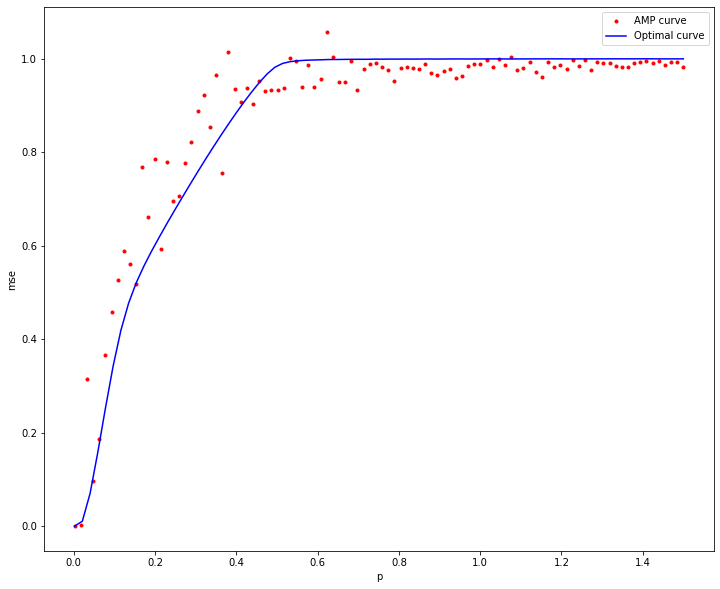

In [325]:
dimension = 100
start = 0.002
end = 1.5
points = 100
prior = 'rademacher'
diag_scalar = 4
off_diag_scalar = 100
delta_collection = create_two_blocks_collection(dimension = dimension, start = start, end = end, points = points, 
                                         first_size = dimension//2, diag_scalar = diag_scalar, 
                                                off_diag_scalar = off_diag_scalar)

amp_curve = data (seeds = 7, dimension = dimension, delta_collection = delta_collection, 
                  initialisation = 'spectral', prior = prior, algorithm = 'amp')
#spectral_curve = data (seeds = 7, dimension = dimension,
 #                                  delta_collection = delta_collection, prior = prior, algorithm = 'spectral')
optimal_curve = optimal_curve(start = start, end = end, points = 80, 
                              diag_scalar = diag_scalar, off_diag_scalar = off_diag_scalar, prior = prior)


spectral_object = {'curve': spectral_curve, 'color': 'green', 'marking': '.', 'label' : 'Spectral curve'}
amp_object = {'curve': amp_curve, 'color': 'red', 'marking': '.', 'label' : 'AMP curve'}
optimal_object = {'curve': optimal_curve, 'color': 'blue', 'marking': '-y', 'label' : 'Optimal curve'}

visualize([amp_object, optimal_object])